In [88]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV


from sklearn.metrics import ConfusionMatrixDisplay , roc_auc_score , accuracy_score
from sklearn.metrics import RocCurveDisplay


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')

In [89]:
dow_categories = ['Monday' , 'Tuesday' , 'Wednesday' , 'Thursday' , 'Friday' , 'Saturday' , 'Sunday']

def is_fatal(details):

    fatal_keywords = [
    'died', 'killed', 'fatal', 'dead', 'mauled to death', 'succumbed',
    'did not survive', 'passed away', 'pronounced dead', 'lost his life',
    'lost her life', 'slain', 'fatally injured', 'mortally wounded'
    ]
    return any(keyword in details.lower() for keyword in fatal_keywords)


def convert_age(age):
    if pd.isna(age) or age == '':  # Handle NaN
        return math.nan
    if isinstance(age, str):
        age = age.strip()  # Remove leading/trailing whitespace
        # Handle months
        if 'months' in age:
            months = int(age.split()[0])
            return months / 12
            
        # Remove non-numeric characters like quotes, and try converting to float
        age = ''.join(filter(str.isdigit, age))
        if age:
            return float(age)
    return age # If it's already a number, return it as is


def encode_date_sin(day , T):
    T = 7  # Total days in a week
    sin_day = np.sin(2 * np.pi * day / T)
    
    return sin_day


def encode_date_cos(day , T):
    T = 7  # Total days in a week
    
    cos_day = np.cos(2 * np.pi * day / T)
    return cos_day

day_to_num = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}

In [90]:
df = pd.read_csv("bear_attacks.csv" )
df['Date'] = pd.to_datetime(df.Date , format = 'mixed' , errors='coerce')
df['year'] = pd.Categorical(df.Date.dt.year.astype('Int64') , ordered=True)
df['month'] = pd.Categorical(df.Date.dt.month.astype('Int64') ,categories = list(range(1 , 13)) )
df['day_of_month'] = pd.Categorical(df.Date.dt.day.astype('Int64') ,categories = list(range(1 , 32)) )
df['day_of_week'] = pd.Categorical(df.Date.dt.day_name() , categories = dow_categories)
df['Fatal'] = df['Details'].apply(is_fatal).astype(int)
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=dow_categories, ordered=True)
df['Gender'] = pd.Categorical(df['Gender'])
df['Age'] = df['Age'].apply(convert_age)
df.loc[df['Age'] == "" , 'Age'] = np.nan

df = df.dropna()
df['day_of_week'] = df['day_of_week'].map(day_to_num)
df['dow_sin'] = df['day_of_week'].apply(encode_date_sin , T = 7)
df['dow_cos'] = df['day_of_week'].apply(encode_date_cos , T = 7)


df['month_sin'] = df['month'].apply(encode_date_sin, T = 12)
df['month_cos'] = df['month'].apply(encode_date_cos, T = 12)

df['Age_2'] = df['Age'] **2
df['Age_3'] = df['Age'] **3

df['Latitude_2'] = df['Latitude'] **2
df['Latitude_3'] = df['Latitude'] **3

df['Longitude_2'] = df['Longitude'] **2
df['Longitude_3'] = df['Longitude'] **3
print(df.shape)
df.head()

(148, 24)


,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,year,...,dow_sin,dow_cos,month_sin,month_cos,Age_2,Age_3,Latitude_2,Latitude_3,Longitude_2,Longitude_3
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33.0,male,2018,...,0.433884,-0.900969,7.818315e-01,0.623490,1089.0,35937.0,4426.794447,294533.050018,7036.218444,-5.902133e+05
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31.0,male,2018,...,0.781831,0.623490,-2.449294e-16,1.000000,961.0,29791.0,3741.430026,228852.910921,8807.850655,-8.266181e+05
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64.0,female,1999,...,-0.433884,-0.900969,-2.449294e-16,1.000000,4096.0,262144.0,3944.959552,247778.621305,8480.152042,-7.809180e+05
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28.0,male,1990,...,-0.974928,-0.222521,-9.749279e-01,-0.222521,784.0,21952.0,4864.058152,339233.034872,26572.667627,-4.331644e+06
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46.0,male,1983,...,0.781831,0.623490,-4.338837e-01,-0.900969,2116.0,97336.0,3453.649028,202963.199918,8866.858519,-8.349388e+05


In [91]:
random_state = 42
df2 = df[['Fatal', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'Age' ,'Age_2',
       'Age_3', 'Latitude_2', 'Latitude_3', 'Longitude_2', 'Longitude_3',
          'Bear']]


df2 = df2.dropna()
X = df2[[ 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'Age' ,'Age_2',
       'Age_3', 'Latitude_2', 'Latitude_3', 'Longitude_2', 'Longitude_3',
          'Bear']]
y = df2['Fatal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y )
print(X_train.shape)
print(X_test.shape)

(118, 12)
(30, 12)


In [92]:
categorical_features = ['Bear']
numerical_features = ['Age' ,'Age_2', 'Age_3', 'Latitude_2', 'Latitude_3', 'Longitude_2', 'Longitude_3']
no_transform_features = ['dow_sin', 'dow_cos', 'month_sin', 'month_cos', ]


# Step 4: Define preprocessors
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
numerical_preprocessor = StandardScaler()

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('cat', categorical_preprocessor, categorical_features),
        ('passthrough', 'passthrough', no_transform_features) 
    ]
)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'feature_selection__k': 1}
AUC score: 0.6206349206349207


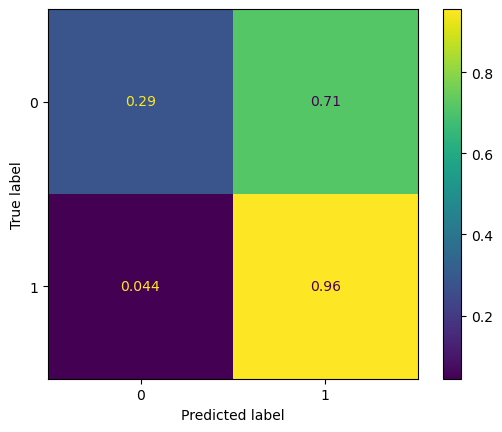

In [93]:
# Step 5: Create a pipeline with a classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', KNeighborsClassifier())
])

# Step 6: Define a parameter grid for grid search
param_grid = {
    'feature_selection__k': [1, 2, 3, 4],  # Number of features to select
    'classifier__n_neighbors': [3, 5, 7],  # Number of neighbors in KNN
    'classifier__weights': ['uniform', 'distance'],  # Weighting scheme
    'classifier__metric': ['euclidean', 'manhattan']  # Distance metric
}

# Step 7: Perform grid search
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 8: Evaluate the best model
knn_best_model = grid_search.best_estimator_
y_pred = knn_best_model.predict(X_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("AUC score:", roc_auc_score(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred , normalize='true' )
plt.show()

Fitting 5 folds for each of 3960 candidates, totalling 19800 fits
Best Parameters: {'classifier__C': 0.08600000000000001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 4}
Logit auc: 0.50


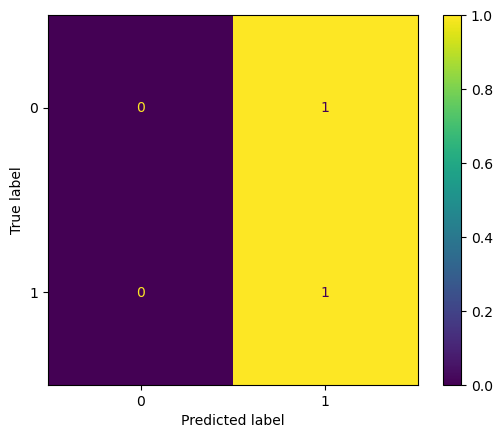

In [94]:
logit_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k= 10)),
    ('classifier', LogisticRegression(max_iter=1000))
])


param_grid = [
    {
        'feature_selection__k': [1, 2, 3, 4],  # Number of features to select
        'classifier__penalty': ['l1'], 
        'classifier__solver': ['liblinear', 'saga'], 
        'classifier__C': np.arange(0.001, 0.1, 0.001)
    },
    {
        'feature_selection__k': [1, 2, 3, 4],  # Number of features to select
        'classifier__penalty': ['l2'], 
        'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'], 
        'classifier__C': np.arange(0.001, 0.1, 0.001)
    },
    {
        'feature_selection__k': [1, 2, 3, 4],  # Number of features to select
        'classifier__penalty': ['elasticnet'], 
        'classifier__solver': ['saga'], 
        'classifier__C': np.arange(0.001, 0.1, 0.001), 
        'classifier__l1_ratio': [0.2, 0.5, 0.8]
    }
]


# Step 5: Perform grid search
grid_search = GridSearchCV(logit_pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, np.ravel(y_train))


# Step 6: Evaluate the best model
logit_best_model = grid_search.best_estimator_
y_pred_logit = logit_best_model.predict(X_train)

# Step 7: Output results
print("Best Parameters:", grid_search.best_params_)
print(f"Logit auc: {roc_auc_score(y_train  , y_pred_logit):.2f}")
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_logit ,   normalize='true' )
plt.show()

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best Parameters: {'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
AUC score: 0.8293650793650793


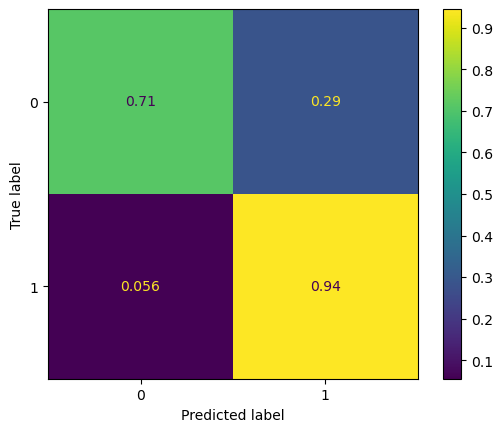

In [95]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=random_state))
])

# Step 6: Define a parameter grid for grid search
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],       
    'classifier__max_depth': [1,2, 3, 4,5,6,7,8,9 ,10],        
    'classifier__min_samples_split': [2, 5, 10],       
    'classifier__min_samples_leaf': [1, 2, 5],         
    'classifier__ccp_alpha': [0.0, 0.01, 0.1]          
}

# Step 7: Perform grid search
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 8: Evaluate the best model
dt_best_model = grid_search.best_estimator_
y_pred = dt_best_model.predict(X_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("AUC score:", roc_auc_score(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred , normalize='true' )
plt.show()

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Best Parameters: {'classifier__C': 1, 'classifier__coef0': 0.1, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'sigmoid', 'feature_selection__k': 10}
Test Accuracy: 0.52


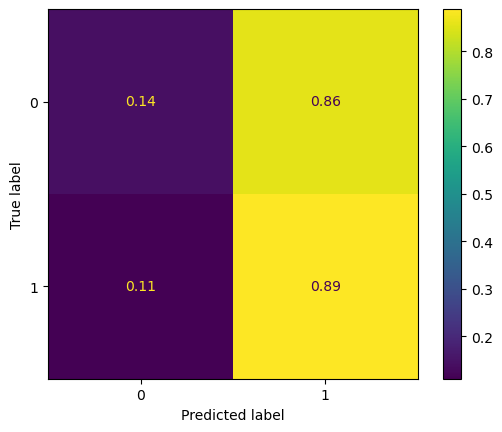

In [96]:
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', SVC(random_state=random_state))
])

param_grid = {
    'feature_selection__k': [1, 2, 3, 5, 10],  # Number of features to select
    'classifier__C': [0.1, 1, 10, 100],  # Regularization strength
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
    'classifier__degree': [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly' kernel)
    'classifier__coef0': [0.0, 0.1, 0.5, 1.0],  # Independent term in kernel function (poly/sigmoid)
}

# Step 5: Perform grid search
grid_search = GridSearchCV(svc_pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 6: Evaluate the best model
svc_best_model = grid_search.best_estimator_
y_pred_svc = svc_best_model.predict(X_train)

# Step 7: Output results
print("Best Parameters:", grid_search.best_params_)
print(f"Test Accuracy: {roc_auc_score(y_train, y_pred_svc):.2f}")
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_svc , normalize='true' )
plt.show()

# Test Results:

Confusion Matrix for KNN classifier
Accuracy: 0.67


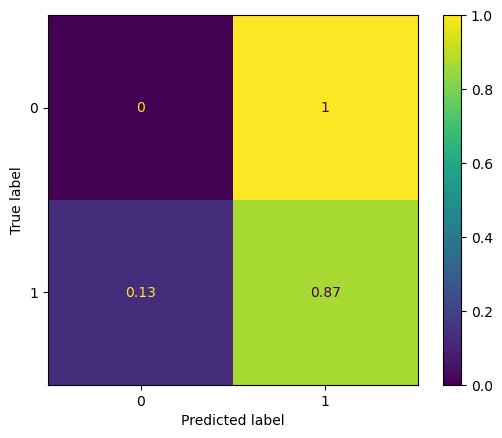

In [97]:
knn_pred = knn_best_model.predict(X_test)
acc = accuracy_score(y_test, knn_pred )
print("Confusion Matrix for KNN classifier")
print(f"Accuracy: {acc:.2f}")
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred , normalize='true' )
plt.show()

Confusion Matrix for Decision Tree classifier
Accuracy: 0.53


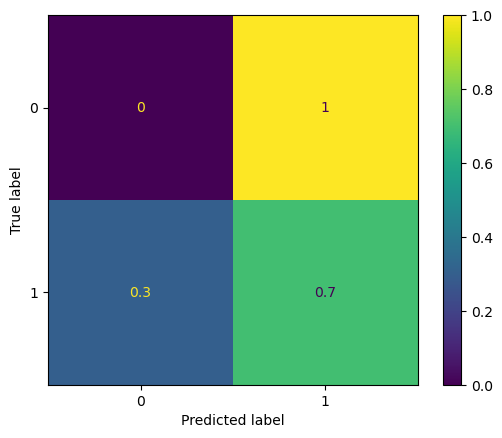

In [98]:
dt_pred = dt_best_model.predict(X_test)
acc = accuracy_score(y_test, dt_pred )
print("Confusion Matrix for Decision Tree classifier")
print(f"Accuracy: {acc:.2f}")
ConfusionMatrixDisplay.from_predictions(y_test, dt_pred , normalize='true' )
plt.show()

# Therefore, the best model is:

## The K Nearest Neighbors with:
### k=3
### distance metric: Eucledian distance
### 

In [99]:
knn_best_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    ['Age', 'Age_2', 'Age_3', 'Latitude_2',
                                     'Latitude_3', 'Longitude_2', 'Longitude_3']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['Bear']),
                                   ('passthrough', 'passthrough',
                                    ['dow_sin', 'dow_cos', 'month_sin',
                                     'month_cos'])])),
  ('feature_selection', SelectKBest(k=1)),
  ('classifier', KNeighborsClassifier(metric='euclidean', n_neighbors=3))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['Age', 'Age_2', 'Age_3', 'Latitude_2',
                                   'Latitude_3', 'Longitude_2', 'Longitude_3']),
                                 ('cat', One

In [110]:
knn_best_model.steps[1][1].get_params()

{'k': 1,
 'score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}